#### In this notebook, causal inference has been performed on selected features. The features were extracted from the feature importance step and the best features used

# Import the necessary packages

In [1]:
import pandas as pd
import causalnex
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas_lasso
from causalnex.plots import plot_structure,NODE_STYLE,EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report,roc_auc
from causalnex.inference import InferenceEngine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

#### Import the dataset containg the most important features

In [2]:
df=pd.read_csv('best_features.csv')
df.head()

,Unnamed: 0,diagnosis,perimeter_worst,radius_worst,concave_points_worst,concavity_mean,area_worst,area_se,perimeter_mean,concavity_worst,area_mean,radius_mean,radius_se,perimeter_se,texture_mean,concave_points_mean,texture_worst
0,0,1,153.2,22.88,0.19320,0.11270,1606.0,53.91,119.6,0.3784,1040.0,18.25,0.4467,3.180,19.98,0.07400,27.66
1,1,1,110.6,17.06,0.15560,0.09366,897.0,50.96,90.2,0.2678,577.9,13.71,0.5835,3.856,20.83,0.05985,28.14
2,2,1,123.8,19.19,0.09975,0.03299,1150.0,40.51,102.7,0.1459,797.8,16.02,0.3795,2.466,23.24,0.03323,33.88
3,3,1,136.5,20.42,0.18100,0.09954,1299.0,54.16,103.6,0.3965,781.0,15.78,0.5058,3.564,17.89,0.06606,27.28
4,4,1,112.0,16.84,0.11190,0.09938,876.5,36.58,103.7,0.2322,782.7,15.85,0.4033,2.903,23.95,0.05364,27.66


In [3]:
df=df.drop(columns='Unnamed: 0')

# Instantiate the model

In [4]:
sm = StructureModel()

In [5]:
# Apply the NOTEARS algorithm to learn the structure.

sm = from_pandas(df)

# Visualize the Structure Model

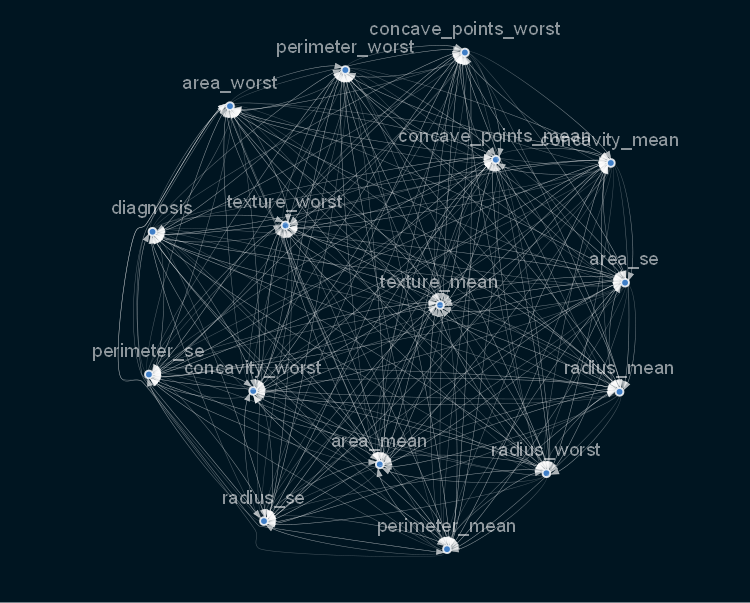

In [6]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

## Edge Pruning
Apply thresholding to the weaker edges of the graph. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.

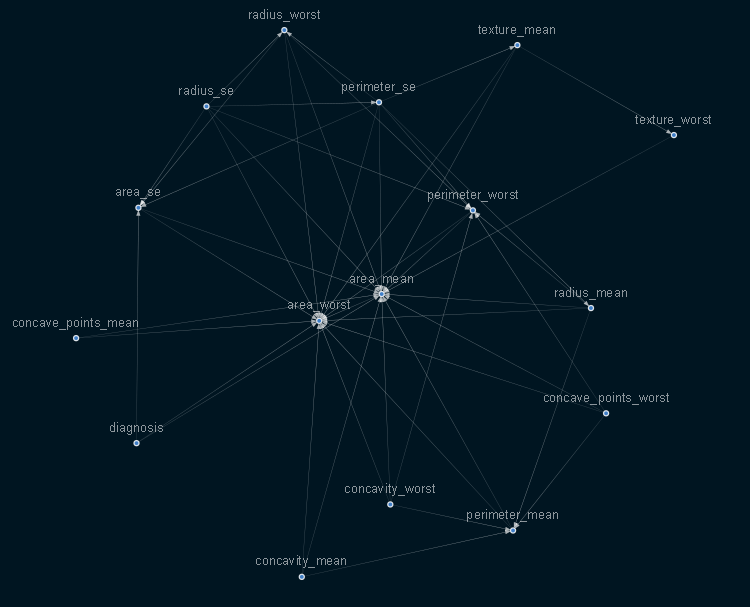

In [7]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

### Correcting the erroneus edges
To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example, we can add and remove edges as:

In [8]:
sm.remove_edge("diagnosis", "area_se")



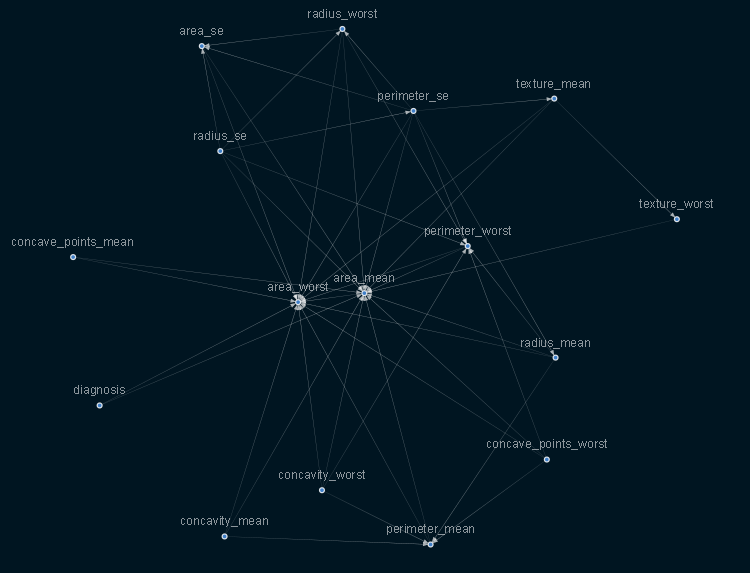

In [9]:
sm_large = sm.get_largest_subgraph()

viz = plot_structure(
    sm_large,
    graph_attributes={"scale": "2.5", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

### Discretising the features
For our data the fixed method will be applied, providing static values that define the bucket boundaries. All the columns will be discretised into uniform (specify the number of buckets and discretizer will create uniformly spaced buckets). Each bucket will be labelled as an integer from zero.

In [25]:
discretised_data=df.copy()
for column in discretised_data.columns:
    discretised_data[column] = Discretiser(method="uniform",num_buckets=10,
                          numeric_split_points=[1, 10]).transform(discretised_data[column].values)
discretised_data.head()

,diagnosis,perimeter_worst,radius_worst,concave_points_worst,concavity_mean,area_worst,area_se,perimeter_mean,concavity_worst,area_mean,radius_mean,radius_se,perimeter_se,texture_mean,concave_points_mean,texture_worst
0,1,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
1,1,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
2,1,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
3,1,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
4,1,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2


In [26]:
for column in discretised_data.columns:
    unique_values=discretised_data[column].unique()
    print(column,unique_values)

diagnosis [1 0]
perimeter_worst [2]
radius_worst [2 1]
concave_points_worst [0]
concavity_mean [0]
area_worst [2]
area_se [2 1]
perimeter_mean [2]
concavity_worst [0]
area_mean [2]
radius_mean [2 1]
radius_se [0]
perimeter_se [1 0]
texture_mean [2 1]
concave_points_mean [0]
texture_worst [2]


In [12]:
bn = BayesianNetwork(sm_large)

In [13]:
# Create labels for the the diagnosis column
diagnosis_map = {0: "Benign", 1: "Malignant"}
discretised_data["diagnosis"] = discretised_data["diagnosis"].map(diagnosis_map)

discretised_data.head()

,diagnosis,perimeter_worst,radius_worst,concave_points_worst,concavity_mean,area_worst,area_se,perimeter_mean,concavity_worst,area_mean,radius_mean,radius_se,perimeter_se,texture_mean,concave_points_mean,texture_worst
0,Malignant,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
1,Malignant,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
2,Malignant,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
3,Malignant,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2
4,Malignant,2,2,0,0,2,2,2,0,2,2,0,1,2,0,2


In [14]:
# Split 90% train and 10% test
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

### Model Probability

Fit the probability distrbution of the Bayesian Network

Specify all of the states that each node can take

In [15]:
bn = bn.fit_node_states(discretised_data)

## Fit Conditional Probability Distributions

Use the dataset to learn the conditional probablilty distributions (CPDs) of each node,along with a method of how to do this fit.

In [16]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")


In [17]:
#inspect the conditional probability distributions of the target variable
bn.cpds["diagnosis"]

,
diagnosis,
Benign,0.752778
Malignant,0.247222


In [18]:
#make predictions
predictions = bn.predict(discretised_data, "diagnosis")

In [19]:
#classification report
classification_report(bn, test, "diagnosis")

{'diagnosis_Benign': {'precision': 0.75,
  'recall': 1.0,
  'f1-score': 0.8571428571428571,
  'support': 30},
 'diagnosis_Malignant': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10},
 'accuracy': 0.75,
 'macro avg': {'precision': 0.375,
  'recall': 0.5,
  'f1-score': 0.42857142857142855,
  'support': 40},
 'weighted avg': {'precision': 0.5625,
  'recall': 0.75,
  'f1-score': 0.6428571428571428,
  'support': 40}}

In [20]:
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

0.75


### Querying Marginals
After iterating over our model structure, CPDs, and validating our model quality, we can query our model under defferent observation to gain insights.

####  Create labels for the other features column

In [21]:
discretised_data_new=discretised_data.copy()
discretised_data_new=discretised_data_new.iloc[:, 1:]
discretised_data_new.head()
# Labeling the features in terms of the buckets created earlier
for column in discretised_data_new.columns:
    features_map={0: "Low", 1: "Medium",2:"High"}
    discretised_data_new[column] = discretised_data_new[column].map(features_map)

diagnosis=discretised_data['diagnosis']
discretised_data_new= discretised_data_new.join(diagnosis)
discretised_data_new.head()

,perimeter_worst,radius_worst,concave_points_worst,concavity_mean,area_worst,area_se,perimeter_mean,concavity_worst,area_mean,radius_mean,radius_se,perimeter_se,texture_mean,concave_points_mean,texture_worst,diagnosis
0,High,High,Low,Low,High,High,High,Low,High,High,Low,Medium,High,Low,High,Malignant
1,High,High,Low,Low,High,High,High,Low,High,High,Low,Medium,High,Low,High,Malignant
2,High,High,Low,Low,High,High,High,Low,High,High,Low,Medium,High,Low,High,Malignant
3,High,High,Low,Low,High,High,High,Low,High,High,Low,Medium,High,Low,High,Malignant
4,High,High,Low,Low,High,High,High,Low,High,High,Low,Medium,High,Low,High,Malignant


### Baseline Marginals
To query the model for baseline marginals that reflect the population as a whole, a query method can be used. First let’s update our model using the complete dataset, since the one we currently have was only built from training data.

In [53]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

For inference, create a new InferenceEngine from the BayesianNetwork, which allows query of the model. The query method will compute the marginal likelihood of all states for all nodes.

In [54]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["diagnosis"]

{'Benign': 0.5, 'Malignant': 0.5}